In [3]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [3]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        # Define attributes
        self.random_state = random_state
        self.k =rank
        self.maxiter = maxiter
        self.tol = tol
        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices,"""
        np.random.seed(self.random_state)   # Set random seed
        self.W = np.random.random((m, self.k))  # Store as attribute
        self.H = np.random.random((self.k, n))
        return self.W, self.H   # Return them

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        # Set up nonnegative matrices of the correct shape
        m, n = np.shape(V)
        self.initialize_matrices(m,n)
        W = cp.Variable((m, self.k), nonneg=True)
        H = cp.Variable((self.k, n), nonneg=True)
    
        while True:
            # Define objective to solve for W
            obj = cp.Minimize(cp.norm(V - W @ self.H, "fro"))
            prob = cp.Problem(objective=obj)
            prob.solve()
            oldW = self.W
            self.W = W.value

            # Define objective to solve for H
            obj = cp.Minimize(cp.norm(V - self.W @ H, "fro"))
            prob = cp.Problem(objective=obj)
            prob.solve()
            oldH = self.H
            self.H = H.value

            # See if the norm is low enough
            if (np.linalg.norm(oldW - self.W, "fro") < self.tol and np.linalg.norm(oldH - self.H, "fro") < self.tol):
                break


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W @ self.H   # Reoncstruct and return V


In [91]:
# Prob 1
NMF = NMFRecommender()
NMF.initialize_matrices(2, 3)
print(NMF.W)
print(NMF.H)

[[0.8488177  0.17889592 0.05436321]
 [0.36153845 0.27540093 0.53000022]]
[[0.30591892 0.30447436 0.11174128]
 [0.24989901 0.9176299  0.26414685]
 [0.71777369 0.86571503 0.80707948]]


In [103]:
V = np.array([[0, 1, 0, 1, 2, 2],
              [2, 3, 1, 1, 2, 2],
              [1, 1, 1, 0, 1, 1],
              [0, 2, 3, 4, 1, 1],
              [0, 0, 0, 0, 1, 0]])
NMF = NMFRecommender()
NMF.fit(V)
print("Reoncstructed V")
print(NMF.reconstruct())

Reoncstructed V
[[1.75030991e-03 9.78621675e-01 4.49053638e-02 9.74447623e-01
  2.10812272e+00 1.90227867e+00]
 [1.99642549e+00 2.84428317e+00 1.23253063e+00 8.71516107e-01
  2.06996039e+00 2.06398729e+00]
 [1.00708073e+00 1.30872590e+00 5.38955262e-01 2.60536350e-01
  8.61120509e-01 8.73319205e-01]
 [1.68443122e-04 2.00887148e+00 2.98656138e+00 4.00744150e+00
  9.94563078e-01 9.97921879e-01]
 [2.25461795e-08 2.04847641e-01 8.26878080e-10 1.97971779e-01
  4.52629742e-01 4.08077284e-01]]


In [115]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    NMF = NMFRecommender(rank=2)  # Create an instance
    NMF.fit(V)   # Fit it

    # Find the number of people with higher weights in compoment 2 than 1
    num = 0
    for i in range(len(NMF.H[0])):
        if(NMF.H[1, i] > NMF.H[0, i]): num += 1

    return NMF.W, NMF.H, num

W, H, num = prob3()
print("W")
print(W)
print("H")
print(H)
print()
print(f"{num} people have higher weights in component 2 than 1")

W
[[4.32357340e-01 1.55958368e+00]
 [7.28830824e-01 2.67353753e+00]
 [2.59497870e-01 1.23222299e+00]
 [2.77133682e+00 7.42173394e-08]
 [2.00262945e-09 3.68909407e-01]]
H
[[6.13701977e-08 7.26310744e-01 1.07593007e+00 1.44659281e+00
  3.52998322e-01 3.65555244e-01]
 [5.85630624e-01 7.72185164e-01 6.58447872e-02 7.09874825e-09
  8.03647818e-01 7.67521958e-01]]

4 people have higher weights in component 2 than 1


In [2]:

#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, mode="F")))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


2677.5208
3338.7957
3254.4963
3236.5085
2994.9668
2074.514
3273.707
3515.7344
2444.279


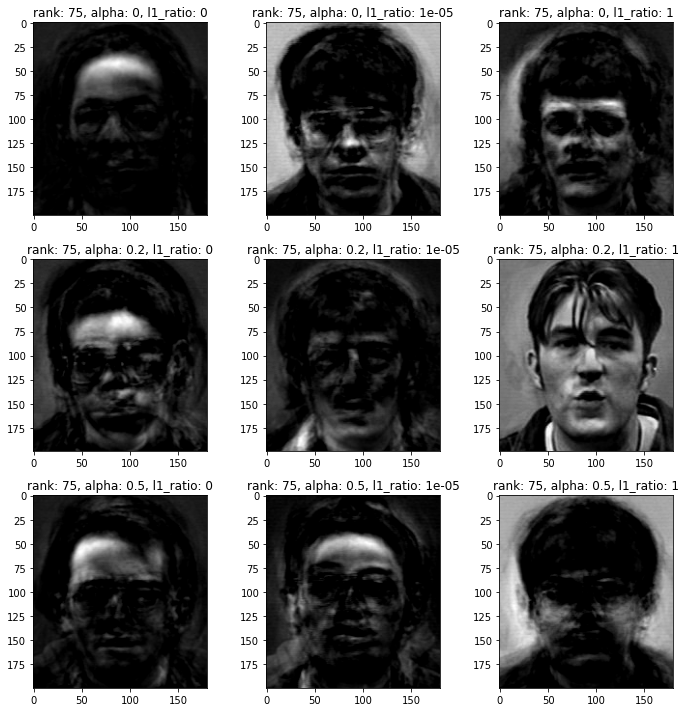

The optimal values are  [75, 0.2, 1]


In [25]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    i = 1
    components = [75]
    alphas = [0, .2, .5]
    l1_ratios = [0, 1e-5, 1]
    faces = get_faces()  # Get the data
    optimal_vals = [np.inf, np.inf, np.inf]
    min_error = np.inf
    plt.figure(figsize=(10,10))   # Set figure size to make it readable
    for n in components:   # Grid search
        for a in alphas:
            for l in l1_ratios:
                # Make the model
                model = NMF(n_components=n, alpha_W=a, l1_ratio=l, init="random") 
                W = model.fit_transform(faces)
                H = model.components_

                error = np.linalg.norm(faces[:,2] - W @ H[:,2])   # Find the error
                print(f"rank: {n}, alpha: {a}, l1_ratio: {l} gives the error: {error}")   # Print it out (so we can see how fast it is going)
                if (error < min_error):
                    optimal_vals = [n, a, l]   # Store the optimal values if error decreased
                    min_error = error

                # Plot the face
                plt.subplot(3, 3, i)
                show(W[:,2])   # Plot just the component
                plt.title(f"rank: {n}, alpha: {a}, l1_ratio: {l}")
                i += 1   # For saving the subplot

    plt.tight_layout()
    plt.show()
    return optimal_vals

optimal_vals = prob4()
print("The optimal values are ", optimal_vals)

rank: 75, alpha: 0, l1_ratio: 0 gives the error: 2802.635009765625
rank: 75, alpha: 0, l1_ratio: 1e-05 gives the error: 2746.71923828125
rank: 75, alpha: 0, l1_ratio: 1 gives the error: 2632.52587890625
rank: 75, alpha: 0.2, l1_ratio: 0 gives the error: 3100.93212890625
rank: 75, alpha: 0.2, l1_ratio: 1e-05 gives the error: 2777.363525390625
rank: 75, alpha: 0.2, l1_ratio: 1 gives the error: 3121.85107421875
rank: 75, alpha: 0.5, l1_ratio: 0 gives the error: 3184.237060546875
rank: 75, alpha: 0.5, l1_ratio: 1e-05 gives the error: 3424.69970703125
rank: 75, alpha: 0.5, l1_ratio: 1 gives the error: 2592.77197265625


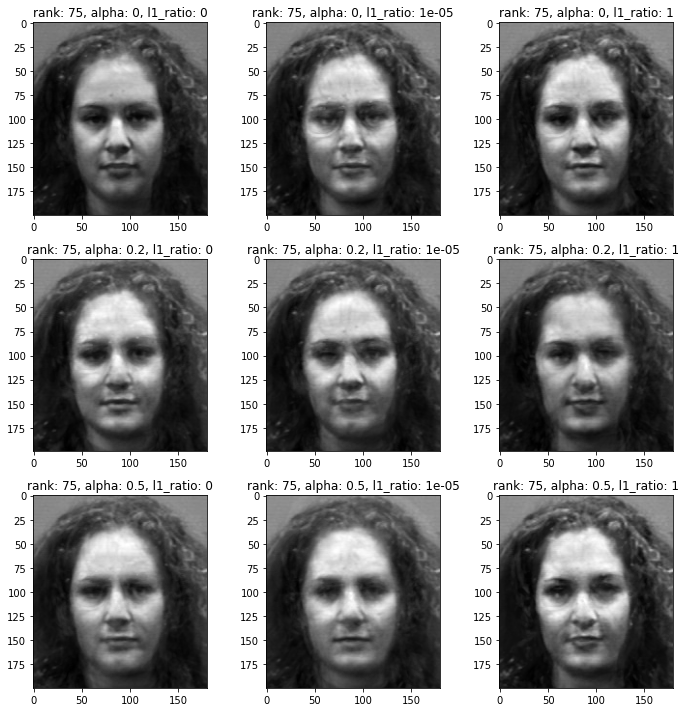

The optimal values are  [75, 0.5, 1]


In [5]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    i = 1
    components = [75]
    alphas = [0, .2, .5]
    l1_ratios = [0, 1e-5, 1]
    faces = get_faces()  # Get the data
    optimal_vals = [np.inf, np.inf, np.inf]
    min_error = np.inf
    plt.figure(figsize=(10,10))   # Set figure size to make it readable
    for n in components:   # Grid search
        for a in alphas:
            for l in l1_ratios:
                # Make the model
                model = NMF(n_components=n, alpha_W=a, l1_ratio=l, init="random") 
                W = model.fit_transform(faces)
                H = model.components_

                error = np.linalg.norm(faces[:,2] - W @ H[:,2])   # Find the error
                print(f"rank: {n}, alpha: {a}, l1_ratio: {l} gives the error: {error}")   # Print it out (so we can see how fast it is going)
                if (error < min_error):
                    optimal_vals = [n, a, l]   # Store the optimal values if error decreased
                    min_error = error

                # Plot the face
                plt.subplot(3, 3, i)
                show(W @ H[:,2]) # Plot recontrusruction
                plt.title(f"rank: {n}, alpha: {a}, l1_ratio: {l}")
                i += 1   # For saving the subplot

    plt.tight_layout()
    plt.show()
    return optimal_vals

optimal_vals = prob4()
print("The optimal values are ", optimal_vals)

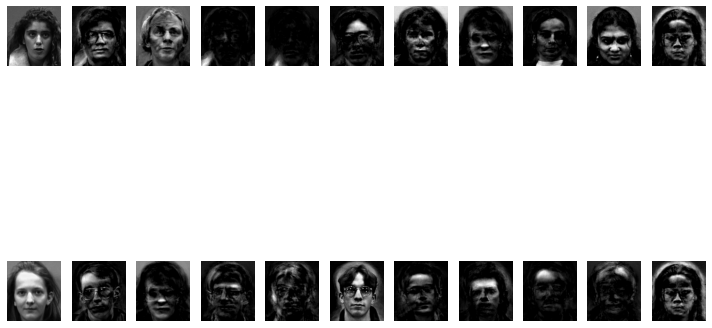

In [19]:
n = 75
a = 0.5
l = 1
    
# H[k, j] represents the abundance of the kth endmember or basis face in the jth image.
# W[:, k] represents the spectral signature of the kth endmember. Then V [:, j] ≊ W H[:, j]
    
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    # Run the model with the optimal parameters
    faces = get_faces()  # Get the data
    model = NMF(n_components=n, alpha_W=a, l1_ratio=l, init="random") 
    W = model.fit_transform(faces)
    H = model.components_
    second_face_indices = np.argsort(H[:,1])[::-1]  # Sort them from largest to smallest
    twelth_face_indices = np.argsort(H[:,11])[::-1]  # Sort them from largest to smallest

    plt.figure(figsize=(10,10))   # Set figure size to make it readable
    plt.subplot(2, 11, 1)  # Plot original faces
    plt.axis("off")   # Gets rid of the x and y axis
    show(faces[:,1])
    plt.subplot(2, 11, 12)
    plt.axis("off")
    show(faces[:,11])

    for i in range(2, 12):   # Plot the basis faces
        plt.subplot(2, 11, i)
        plt.axis("off")
        show(W[:, second_face_indices[i - 2]])
        plt.subplot(2, 11, i + 11)
        plt.axis("off")
        show(W[:, twelth_face_indices[i - 2]])
    plt.tight_layout()
    plt.axis("off")
    plt.show()

prob5()

Running the NMF on the facial data set with the optimal parameters yielded the results above. The images on the left are the orignial images and the ones on the right are the basis faces with the largest coefficients (the ones that play the largest role in making the face). The graph is small since it is hard to fit on one screen. But, it is still legible enough to discern detail.

For the first facwe, I noticed that most of the basis faces have curly or large hair whereas the hair is straighter on the basis faces of the second face. Another thing I notices is that on the second face, more of the basis faces have ears visible. This is likely because the second face has visible ears as well. Overall, the basis faces more closely resemble the face they are next to. But, many of the features are difficult to put into words